In [13]:
from controllers import *
wipeFolder('Aspen Stuff')

File does not exist: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\greenLightAspen
File does not exist: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\greenLightPython
File does not exist: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\u.txt
File does not exist: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\dynamicValues.txt
File deletion process completed.


In [14]:
netSteps = int(tFinal/delta)
targetTemps = np.array([0, 0])
#targetTemps = np.array([0,0])
Kc=np.array([500, 50])
Ki=np.array([0.1, 0.01])

# Initial Values
initialValues = np.loadtxt(os.path.join('Aspen Stuff', 'initialValues.txt'), delimiter=",")
C_B1_i   = initialValues[0,0] - C_B1s    # kmol/m3
C_DEB1_i = initialValues[0,1] - C_DEB1s  # kmol/m3
C_E1_i   = initialValues[0,2] - C_E1s    # kmol/m3
C_EB1_i  = initialValues[0,3] - C_EB1s   # kmol/m3
T_1_i    = initialValues[0,4] - T_1s     # K
C_B2_i   = initialValues[1,0] - C_B2s    # kmol/m3
C_DEB2_i = initialValues[1,1] - C_DEB2s  # kmol/m3
C_E2_i   = initialValues[1,2] - C_E2s    # kmol/m3
C_EB2_i  = initialValues[1,3] - C_EB2s   # kmol/m3
T_2_i    = initialValues[1,4] - T_2s     # K

# Initialize the state, control, and error Records
stateRecord = np.zeros((2,5,netSteps+1))
stateRecord[0,0,0] = C_B1_i
stateRecord[0,1,0] = C_DEB1_i
stateRecord[0,2,0] = C_E1_i
stateRecord[0,3,0] = C_EB1_i
stateRecord[0,4,0] = T_1_i
stateRecord[1,0,0] = C_B2_i
stateRecord[1,1,0] = C_DEB2_i
stateRecord[1,2,0] = C_E2_i
stateRecord[1,3,0] = C_EB2_i
stateRecord[1,4,0] = T_2_i

controlRecord = np.zeros((2,netSteps))

errorRecord = [[] for _ in controlRecord]


# Storing the steady state values in 2 arrays
x_ss = np.array([[ C_B1s,C_DEB1s, C_E1s,C_EB1s,  T_1s], [ C_B2s,C_DEB2s,C_E2s, C_EB2s,  T_2s]])
print(f"The steady state values are {x_ss}")

# Transfer the initial values into realtime array, wont store the data permanently, created record lists for that.
currentState = np.array([[ C_B1_i,C_DEB1_i,C_E1_i, C_EB1_i,  T_1_i], [ C_B2_i, C_DEB2_i,C_E2_i, C_EB2_i, T_2_i]])
print(f"The initial values are {currentState}")

lowerBounds = [-4e3,-3e4]       # Max cooling = 10 * heat needed to sustain first principles steady state.
upperBounds = [5e3-Q1s,5e3-Q2s] # Max heating = heat needed to raise 60m^3 or water by 80K in 1hr

The steady state values are [[6.37085258e+00 4.62942329e-06 1.53852736e+00 3.94391610e-01
  3.29999880e+02]
 [4.61303031e+00 1.26810586e-04 4.69322144e-01 1.38258850e+00
  3.80029296e+02]]
The initial values are [[ 5.86732155e-01 -4.59839468e-06  4.19075269e-01 -3.52001479e-01
  -2.99998800e+01]
 [ 1.82198751e+00 -1.26782400e-04  1.49177169e+00 -1.34385631e+00
  -8.00292962e+01]]


In [15]:
Coeff1 = F1/V1
Coeff2 = F1/V2
Coeff3 = F2_new/V2
@njit
def model_makestep(x,u, steps=100, hc=1e-4):
    C_B1,C_DEB1,C_E1,C_EB1,T_1,C_B2,C_DEB2,C_E2,C_EB2,T_2 = x
    Q1,Q2 = u
    for _ in range(steps):
        r1_1  = k_1*math.exp(-E_1/R/(T_1+T_1s))*((C_B1+C_B1s)*(C_E1+C_E1s))
        r1s_1 = k_1*math.exp(-E_1/R/T_1s)*(C_B1s*C_E1s)
        r2_1  = k_2*math.exp(-E_2/R/(T_1+T_1s))*((C_EB1+C_EB1s)*(C_E1+C_E1s))
        r2s_1 = k_2*math.exp(-E_2/R/T_1s)*(C_EB1s*C_E1s)
        r3_1  = k_3*math.exp(-E_3/R/(T_1+T_1s))*((C_B1+C_B1s)*(C_DEB1+C_DEB1s))
        r3s_1 = k_3*math.exp(-E_3/R/T_1s)*(C_B1s*C_DEB1s) 

        r1_2  = k_1*math.exp(-E_1/R/(T_2+T_2s))*((C_B2+C_B2s)*(C_E2+C_E2s))
        r1s_2 = k_1*math.exp(-E_1/R/T_2s)*(C_B2s*C_E2s)
        r2_2  = k_2*math.exp(-E_2/R/(T_2+T_2s))*((C_EB2+C_EB2s)*(C_E2+C_E2s))
        r2s_2 = k_2*math.exp(-E_2/R/T_2s)*(C_EB2s*C_E2s)
        r3_2  = k_3*math.exp(-E_3/R/(T_2+T_2s))*((C_B2+C_B2s)*(C_DEB2+C_DEB2s))
        r3s_2 = k_3*math.exp(-E_3/R/T_2s)*(C_B2s*C_DEB2s)

        C_B1   = max(-C_B1s,C_B1+hc*(Coeff1*(-C_B1)                            - r1_1 + r1s_1  - r3_1 + r3s_1))
        C_B2   = max(-C_B2s,C_B2+hc*(Coeff2*(C_B1-C_B2)     + Coeff3*(-C_B2)   - r1_2 + r1s_2  - r3_2 + r3s_2))
        C_DEB1 = max(-C_DEB1s,C_DEB1+hc*(Coeff1*(-C_DEB1)                          + r2_1 - r2s_1 - r3_1 + r3s_1))
        C_DEB2 = max(-C_DEB2s,C_DEB2+hc*(Coeff2*(C_DEB1-C_DEB2) + Coeff3*(-C_DEB2) + r2_2 - r2s_2 - r3_2 + r3s_2))
        C_E1   = max(-C_E1s,C_E1+hc*(Coeff1*(-C_E1)                            - r1_1 + r1s_1  - r2_1 + r2s_1))
        C_E2   = max(-C_E2s,C_E2+hc*(Coeff2*(C_E1-C_E2)     + Coeff3*(-C_E2)   - r1_2 + r1s_2  - r2_2 + r2s_2))
        C_EB1  = max(-C_EB1s,C_EB1+hc*(Coeff1*(-C_EB1)                           + r1_1 - r1s_1  - r2_1 + r2s_1 + 2*(r3_1-r3s_1)))
        C_EB2  = max(-C_EB2s,C_EB2+hc*(Coeff2*(C_EB1-C_EB2)   + Coeff3*(-C_EB2)  + r1_2 - r1s_2  - r2_2 + r2s_2 + 2*(r3_2-r3s_2)))
        T_1    = max(-T_1s,T_1+hc*(Coeff1*(-T_1)                    - H_1*(r1_1-r1s_1)/(rhoe_L1*Cp1) - H_2*(r2_1-r2s_1)/(rhoe_L1*Cp1)- H_3*(r3_1-r3s_1)/(rhoe_L1*Cp1) +Q1/(rhoe_L1 * Cp1 * V1)))
        T_2    = max(-T_2s,T_2+hc*(Coeff2*(T_1-T_2) + Coeff3*(-T_2) - H_1*(r1_2-r1s_2)/(rhoe_L2*Cp2) - H_2*(r2_2-r2s_2)/(rhoe_L2*Cp2)- H_3*(r3_2-r3s_2)/(rhoe_L2*Cp2) +Q2/(rhoe_L2 * Cp2 * V2)))
    return np.array([C_B1,C_DEB1,C_E1,C_EB1,T_1,C_B2,C_DEB2,C_E2,C_EB2,T_2])



In [16]:
from controllers import *
#Saving the results to text files
stateNames = ['C_B_1_record', 'C_DEB_1_record', 'C_E_1_record', 'C_EB_1_record', 'T_1_record', 'C_B_2_record', 'C_DEB_2_record', 'C_E_2_record', 'C_EB_2_record', 'T_2_record']
controlNames = ['Q_1_record', 'Q_2_record']

#wipeFolder('Aspen Stuff')
#Transfer the initial values into realtime array, wont store the data permanently, created record lists for that. 
inputFile = os.path.join('Aspen Stuff', 'u.txt')
start_time = time.time()
for num_iter in range(netSteps):
    u = solvePI(T=stateRecord[:,-1,num_iter],
                T_setpoint=targetTemps,
                Kc=Kc,
                Ki=Ki,
                PIcontrolStepSize=PIcontrolStepSize,
                hc=hcPI,
                lowerBounds = lowerBounds,
                upperBounds = upperBounds,
                errorRecord = errorRecord,
                encrypted = False, 
                isArray = True)

    # Define the initial values of the Control Variables
    controlRecord[0][num_iter] =  u.item(0)
    controlRecord[1][num_iter] =  u.item(1)
    
    # # Apply MPC inputs directly to the first-principles model
    # inputs = [u.item(0), u.item(1)]

   
    # x = stateRecord[:,:,num_iter].reshape(-1)
    # dynamicData = model_makestep(x,inputs, controlStepSize, hcMPC)

    # # Update the state record based on first-principles model outputs
    # dynamicData = dynamicData.reshape(2, 5)
    
    # stateRecord[:, :, num_iter + 1] = dynamicData
    np.savetxt(inputFile, controlRecord[:,num_iter]+[Q1s,Q2s], fmt ='%.5f')
    open(os.path.join('Aspen Stuff', 'greenLightAspen'), 'w').close()

    # Load data from Aspen
    file = os.path.join('Aspen Stuff', 'greenLightPython')
    print(f"Waiting for Aspen to send data...(Iteration #{num_iter+1})",end='\r')
    while not os.path.isfile(file):
        pass
    print(f"Aspen Data found.",end='\r')
    dynamicData =np.loadtxt(os.path.join('Aspen Stuff', 'dynamicValues.txt'), delimiter = ",")
    while os.path.isfile(file):
        try:
            os.remove(file)
        except PermissionError:
            pass
    stateRecord[:,:,num_iter+1] = dynamicData - x_ss
    for i, name in enumerate(stateNames):
        file = os.path.join('Results_PIcontrol', f'{name}.txt')
        np.savetxt(file, stateRecord[i//5,i%5,:])
    for i, name in enumerate(controlNames):
        file = os.path.join('Results_PIcontrol', f'{name}.txt')
        np.savetxt(file, controlRecord[i,:])
    file = os.path.join('Results_PIcontrol', 'finalIteration.txt')
    np.savetxt(file, [num_iter+1],fmt='%i')

end_time = time.time()

total_runtime = end_time - start_time
print("Total time required to execute the code = %f seconds " % total_runtime)

Total time required to execute the code = 1494.492392 seconds 


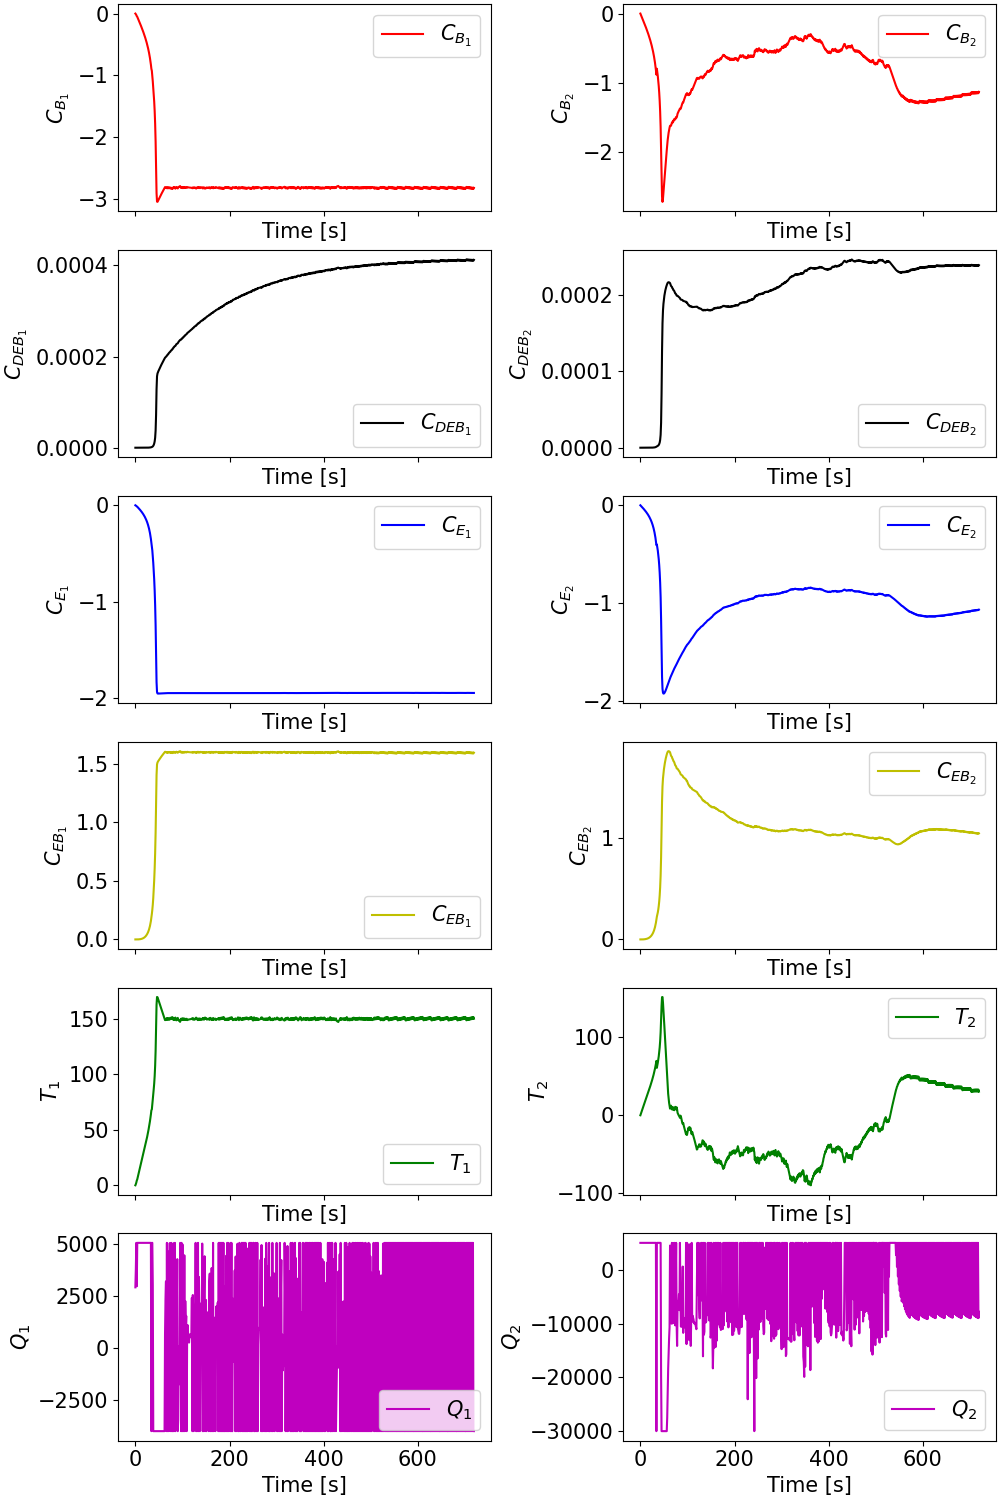

In [18]:
from controllers import *
%matplotlib widget
plt.rcParams['font.size'] = 15
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
plt.rcParams['ps.fonttype'] = 42   # Also for PostScript outputs
plt.rcParams['text.usetex'] = False
plt.gcf().align_ylabels()
plt.close('all')
fig = plt.figure(figsize = (10,15))
grid = fig.add_gridspec(6,2,hspace = 0)
axes = grid.subplots(sharex=True,sharey=False)

stateNames = np.array(['C_B_1_record', 'C_DEB_1_record', 'C_E_1_record', 'C_EB_1_record', 'T_1_record', 'C_B_2_record', 'C_DEB_2_record', 'C_E_2_record', 'C_EB_2_record', 'T_2_record']).reshape(2,5)
controlNames = ['Q_1_record', 'Q_2_record']

#Plotting the results
colors = ['r', 'k', 'b', 'y', 'g','m']
labels = ['C_{B', 'C_{DEB', 'C_{E', 'C_{EB', 'T','Q']

for i in range(6):
        for j in range(2):
            if i<4:
                latex_label = f"${labels[i]}_{{{j+1}}}}}$"
            else:
                latex_label = f"${labels[i]}_{{{j+1}}}$"
            if i==5:
                axes[i,j].plot(np.loadtxt(os.path.join('Results_PIcontrol', f'{controlNames[j]}.txt'), delimiter = ",")[:np.loadtxt(os.path.join('Results_PIcontrol', 'finalIteration.txt'), delimiter = ",",dtype=int)],colors[i],label=latex_label)
            else:    
                axes[i,j].plot(np.loadtxt(os.path.join('Results_PIcontrol', f'{stateNames[j,i]}.txt'), delimiter = ",")[:np.loadtxt(os.path.join('Results_PIcontrol', 'finalIteration.txt'), delimiter = ",",dtype=int)],colors[i],label=latex_label)
            axes[i,j].set_xlabel('Time [s]')
            axes[i,j].set_ylabel(latex_label)
            axes[i,j].legend()

# for i in range(6):
#     for j in range(2):
#         if i<4:
#             latex_label = f"${labels[i]}_{{{j+1}}}}}$"
#         else:
#             latex_label = f"${labels[i]}_{{{j+1}}}$"
#         if i==5:
#             axes[i,j].plot(controlRecord[j,:num_iter+1],colors[i],label=latex_label)
#         else:    
#             axes[i,j].plot(stateRecord[j,i,:num_iter+1],colors[i],label=latex_label)
#         axes[i,j].set_xlabel('Time [s]')
#         axes[i,j].set_ylabel(latex_label)
#         axes[i,j].legend()
# Adjust the layout so plots do not overlap
#plt.tight_layout()
plt.show()